# Classification

## MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

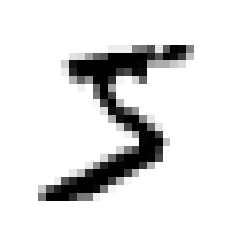

In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_img = some_digit.reshape(28, 28)

plt.imshow(some_digit_img, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
import numpy as np

y = y.astype(np.uint8)

y[0]

5

In [6]:
# MNIST is already split into training and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier
For start let's make a binary classifier that will indentify single digit - digit 5.

In [7]:
y_train_5, y_test_5 = (y_train == 5), (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

#### Implementing Cross-Validation
Following code is roughly equivalent to *Scikit-Learn*'s function `cross_val_score`.

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_ix, test_ix in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_ix]
    y_train_folds = y_train_5[train_ix]
    
    X_test_folds = X_train[test_ix]
    y_test_folds = y_train_5[test_ix]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = np.sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

This seems pretty good! However, let's check a classifier that always classifies an image as **not 5**.

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Over 90% accuracy! Well, the problem is that just about 10% of the whole dataset are images of 5 (there are 10 numbers in total). Hence the 90% accuracy.

### Confusion Matrix
The idea of a *confusion matrix* is to count the number of times class A is classified as class B and so on. 

To compute the confusion matrix one must first get predicions (here on the train set, let's keep test set aside). We can take predictions for a cross-validation with `cross_val_predict` and pass them to `confusion_matrix`.

For a binary classification the confusion matrix looks like this:

|     | N  | P  |
|-----|----|----|
| N   | TN | FP |
| P   | FN | TP |

Rows are the *actual* class and columns are the predicted class, furthermore
* *P* - *positive* (class)
* *N* - *negative* (class)
* *TN* - *true negative*
* *TP* - *true positive*
* *FN* - *false negative*
* *FP* - *false negative*

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [13]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

**Precision** is the accuracy of positive predictions and is defined as $\text{precision} = \frac{TP}{TP + FP}$

*Trivial way to ensure 100% precision is to make single prediction and make sure it's correct.*

**Recall (sensitivity, true positive rate)** is the ratio of positive instances that are correctly detected and is defined as $\text{recall} = \frac{TP}{TP + FN}$

Intuitive notion of precision and recall:
* *precision* - how often is the predictor correct when the actual class is the positive one
* *recall* - how likely does the predictor detect the positive class

In [14]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
precision, recall

(0.8370879772350012, 0.6511713705958311)

Precision and recall are handy but it's even better to have single score based on which we can compare classifiers.

$\mathbf{F_1}$ score is the *harmonic mean* of precision and recall. Regular mean puts the same weight to all values, harmonic mean gives much more importance to lower values. So in order to have high $F_1$ score, both precision and mean must be high.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}
$$

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/Recall Trade-off
*Increasing precision reduces recall and vice versa.*

How does the classification work? The `SGDClassifier`, for instance, computes for each instance a score based on a *decision function*. If this score is greater than *decision threshold*, it assigns the instance to the positive class. Shifting this threshold will likely result a change in precision and recall.

In [16]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [17]:
def predict_some_digit(threshold):
    return (y_scores > threshold)

# Raising the threshold decreases recall
predict_some_digit(threshold=0), predict_some_digit(threshold=8000)

(array([ True]), array([False]))

From the example above, increasing the decision threshold decreases recall (`some_digit` is actually a 5 and with the increased thresholt is is no longer recognized).

But how to decide which threshold to use?

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

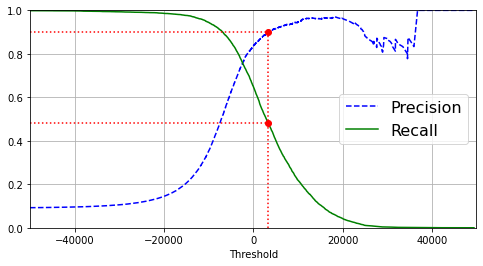

In [19]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center right', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

plt.figure(figsize=(8, 4))

# plot precision and recall curves vs decision threshold
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

# plot threshold corresponding to 90% precision
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')

# plot precision level up to 90% precision threshold
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')

# plot recall level up to 90% precision threshold
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')

# plot points on precision and recall curves corresponding to 90% precision threshold
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')

plt.show()

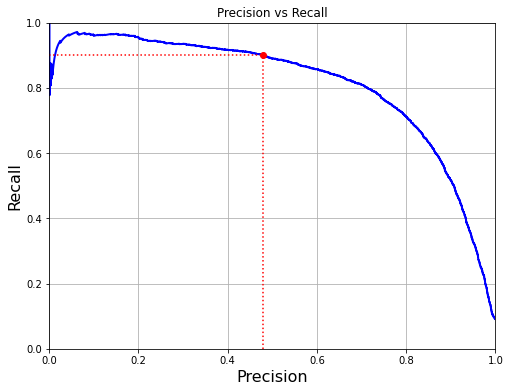

In [20]:
plt.figure(figsize=(8, 6))

# plot precision vs recall
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)

# style the plot
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision vs Recall')

# plot 90% precision point
plt.plot([recall_90_precision], [0.9], 'ro')
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], 'r:')
plt.plot([0.0, recall_90_precision], [0.9, 0.9], 'r:')

plt.show()

In [21]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_90 = precision_score(y_train_5, y_train_pred_90)
recall_90_precision = recall_score(y_train_5, y_train_pred_90)
precision_90, recall_90_precision

(0.9000345901072293, 0.4799852425751706)

### The ROC Curve
The **receiver operating characteristic** curve is similar to precesion-recall curve but instead plots *true positive rate (recall, sensitivity)* agains *false positive rate* (FPR). The FPR is 1 minus *true negative rate rate (specificity*. I.e. ROC curve plots *sensitivity* against 1 - *specificity*.

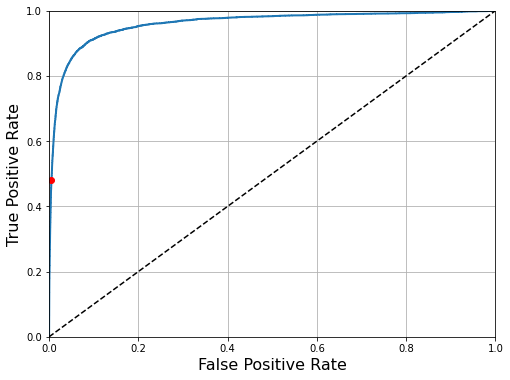

In [22]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.grid(True)

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

plt.figure(figsize=(8, 6))

# plot the ROC curve
plot_roc_curve(fpr, tpr)

# plot point of 90% precision on the ROC curve
plt.plot([fpr_90], [recall_90_precision], 'ro')

plt.show()

Another way to compare classifiers is to measure the **area under the curve (AUC)**. Prfect classifier would have AUC score of 1 whereas completely random one would have 0.5 (this corresponds to the diagonal line in the ROC plot).

In [23]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As a rule of thumb, use PR curve when
* positive class is rare
* we care more about the false positives

otherwise ROC curve might be better.

*For instance in the plot above, it might seem that the AUC is quite good but that's just because there's only few examples of the positive class (5s). In this case, the PR curve presents much more realistic view.*

Following example shows a DT which does not have a `decision_function` method. Instead, it has `predict_proba` method returning class probabilities. In general *Scikit-Learn* models will have one or the other method or both.

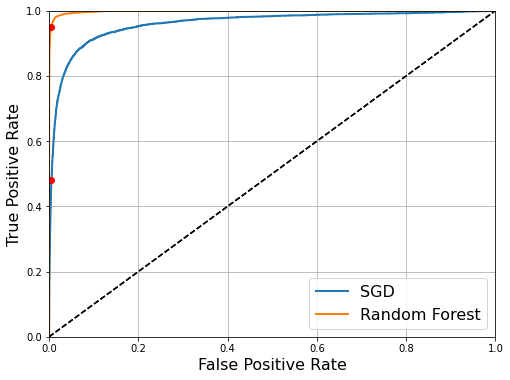

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_proba_forest[:, 1]  # score = probability of the positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
recall_90_precision_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))

# plot the ROC curve of the SGD
plot_roc_curve(fpr, tpr, label='SGD')

# plot the ROC curve of the Random Forest
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')

# plot point of 90% precision on the SGD ROC curve
plt.plot([fpr_90], [recall_90_precision], 'ro')

# plot point of 90% precision on the Random Forest ROC curve
plt.plot([fpr_90], [recall_90_precision_forest], 'ro')

plt.legend(loc='lower right', fontsize=16)

plt.show()

## Multiclass Classification

**Multiclass (Multinominal) Classifiers**:
* *Logistic Regression*
* *Random Forrest*
* *Naive Bayes*

**Binary Classifiers**:
* *SGD*
* *SVM*

Strategies to turn binary classifiers into multiclass:
* **One-versus-the-rest (OvR)**: Train one classifier per class. When predicting class for new instance, get the score from each one and choose the class with the highest score.
* **One-versus-one (OvO)**: Train one classifier for each pair of classes (for $N$ classes it's $N \times (N - 1) / 2$ classifiers). When predicting, run the instance through all classifiers and choose class which wins the most duels. Main advantage is that each classifier needs only portion of the training set which contains it's pair of classes which is good for classifiers which don't scale well (e.g. SVM).

In [28]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])

svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [29]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [30]:
some_digit_class = np.argmax(some_digit_scores)
svm_clf.classes_[some_digit_class]

5

One can manually select the strategy by wrapping the model class into `OneVsRestClassifier` or `OneVsOneClassifier`.

In [31]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [32]:
len(ovr_clf.estimators_)

10

`SGDClassifier` uses *OvR* under the hood

In [33]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [34]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [35]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

CV on the SGD classifier shows pretty good accuracy compared to dummy (random) classifier which would have around 10%. This can be improved even further by simply scaling the input.

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [37]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

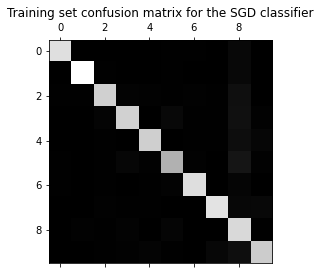

In [38]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.title('Training set confusion matrix for the SGD classifier')
plt.show()

Let's transform the confusion matrix a bit to focus on the errors:
1. divide each value by the number of instances (images in this case) in that class
1. fill diagonal with zeros to keep just the errors

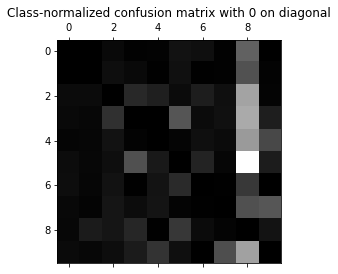

In [39]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title('Class-normalized confusion matrix with 0 on diagonal')
plt.show()